In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
train_gen = ImageDataGenerator(
    fill_mode='nearest',
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.4, 1.4],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.15,)

test_gen = ImageDataGenerator(rescale=1./255)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_generator = train_gen.flow_from_directory(
    '/content/drive/MyDrive/dataset/Dataset for Train test/train',
    target_size=(128,128),
    batch_size=4,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
)

val_generator = train_gen.flow_from_directory(
    '/content/drive/MyDrive/dataset/Dataset for Train test/train',
    target_size=(128,128),
    batch_size=4,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
)

Found 1050 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


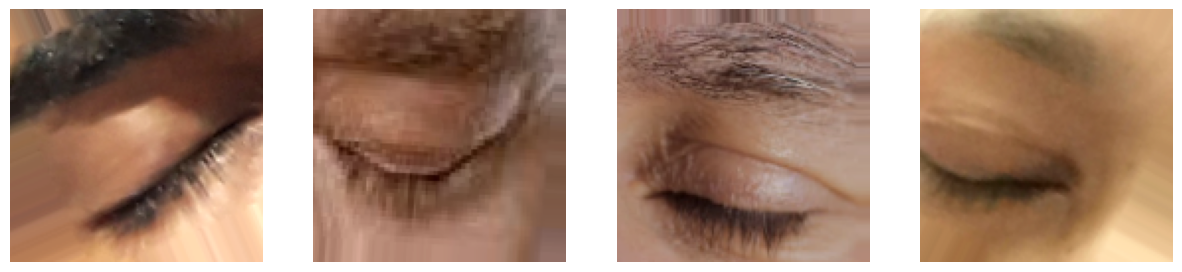

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(train_generator)[0].astype('float16')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image[0].astype('float32'))
  ax[i].axis('off')

In [6]:
resnet_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', classes = 2, input_shape = (128,128,3))
resnet_model.trainable = True
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [7]:
train_generator.class_indices

{'Closed': 0, 'Open': 1}

In [8]:
len(train_generator) * train_generator.batch_size

1052

In [9]:
# set_trainable=False

# for layer in resnet_model.layers:
#     if layer.name=='conv4_block1_1_conv':
#         set_trainable=True
#     layer.trainable=set_trainable

In [10]:
# for layer in resnet_model.layers:
#     print(layer.name, layer.trainable)

In [11]:
model=Sequential([
    resnet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')])

In [12]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 40,431,362
Trainable params: 40,378,242
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
history = model.fit(
    train_generator,
    epochs=50,
    shuffle=True,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
)

Epoch 1/50
263/263 [==============================] - 62s 78ms/step - loss: 0.5199 - accuracy: 0.9448 - val_loss: 1.6188 - val_accuracy: 0.5000
Epoch 2/50
263/263 [==============================] - 22s 84ms/step - loss: 0.1002 - accuracy: 0.9867 - val_loss: 2.0976 - val_accuracy: 0.5217
Epoch 3/50
263/263 [==============================] - 18s 68ms/step - loss: 0.0719 - accuracy: 0.9867 - val_loss: 0.3679 - val_accuracy: 0.8152
Epoch 4/50
263/263 [==============================] - 18s 68ms/step - loss: 0.0111 - accuracy: 0.9952 - val_loss: 0.0354 - val_accuracy: 0.9891
Epoch 5/50
263/263 [==============================] - 18s 68ms/step - loss: 9.6091e-04 - accuracy: 1.0000 - val_loss: 0.0444 - val_accuracy: 0.9891
Epoch 6/50
263/263 [==============================] - 22s 82ms/step - loss: 0.0372 - accuracy: 0.9905 - val_loss: 0.2725 - val_accuracy: 0.9674
Epoch 7/50
263/263 [==============================] - 18s 68ms/step - loss: 0.0427 - accuracy: 0.9914 - val_loss: 0.2286 - val_accur

In [15]:
test_generator = test_gen.flow_from_directory(
    '/content/drive/MyDrive/dataset/Dataset for Train test/test',
    target_size=(128,128),
    batch_size=4,
    color_mode='rgb',
    class_mode='categorical',
)

Found 218 images belonging to 2 classes.


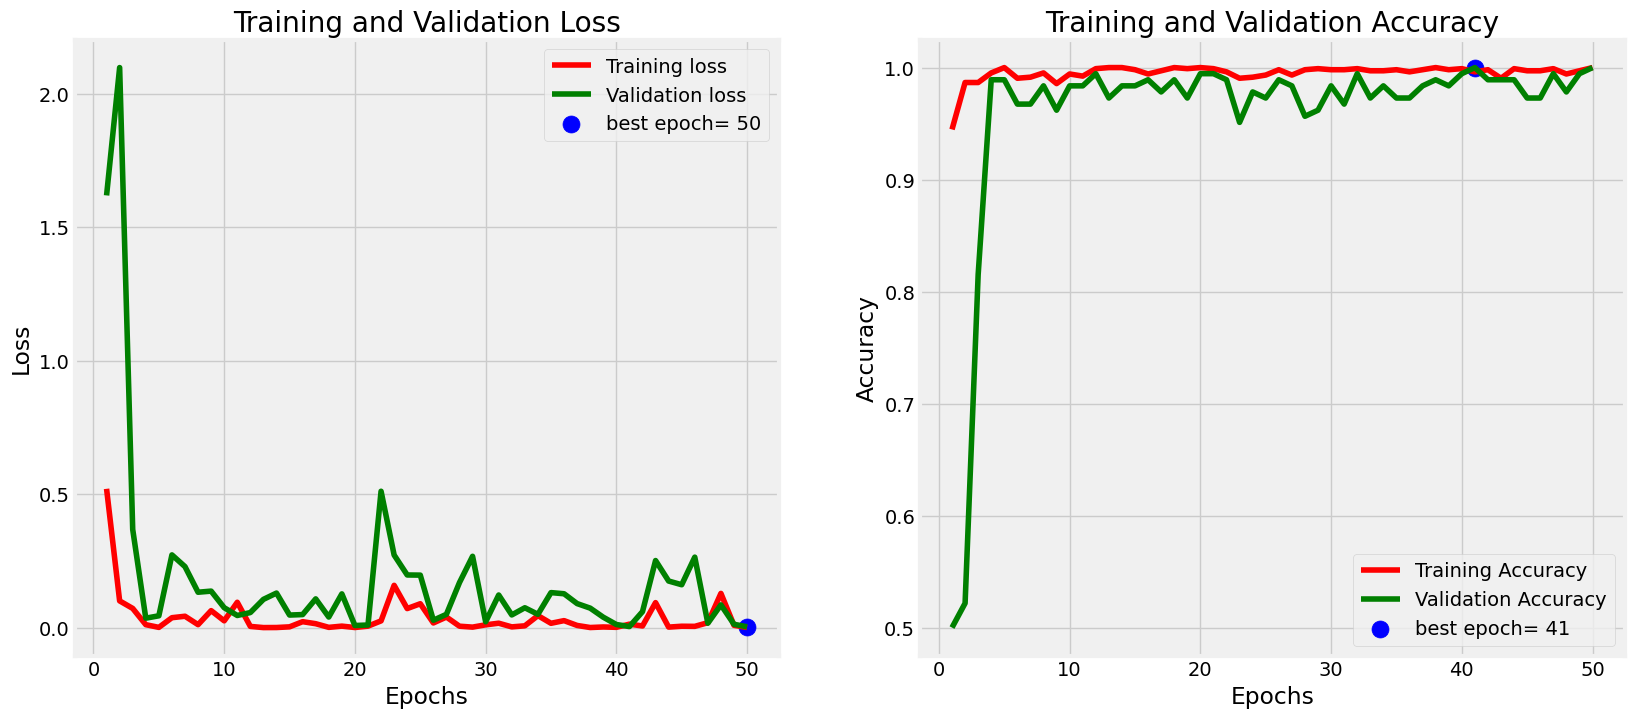

In [16]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [17]:
ts_length = len(test_generator)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_generator, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 0s 68ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Train Loss:  6.258479743337375e-07
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0
Test Accuracy:  1.0


In [65]:
pred = model.predict(test_generator)
y_pred = np.argmax(pred,axis = 1)

55/55 [==============================] - 2s 34ms/step


In [66]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())
classes

['Closed', 'Open']

In [67]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

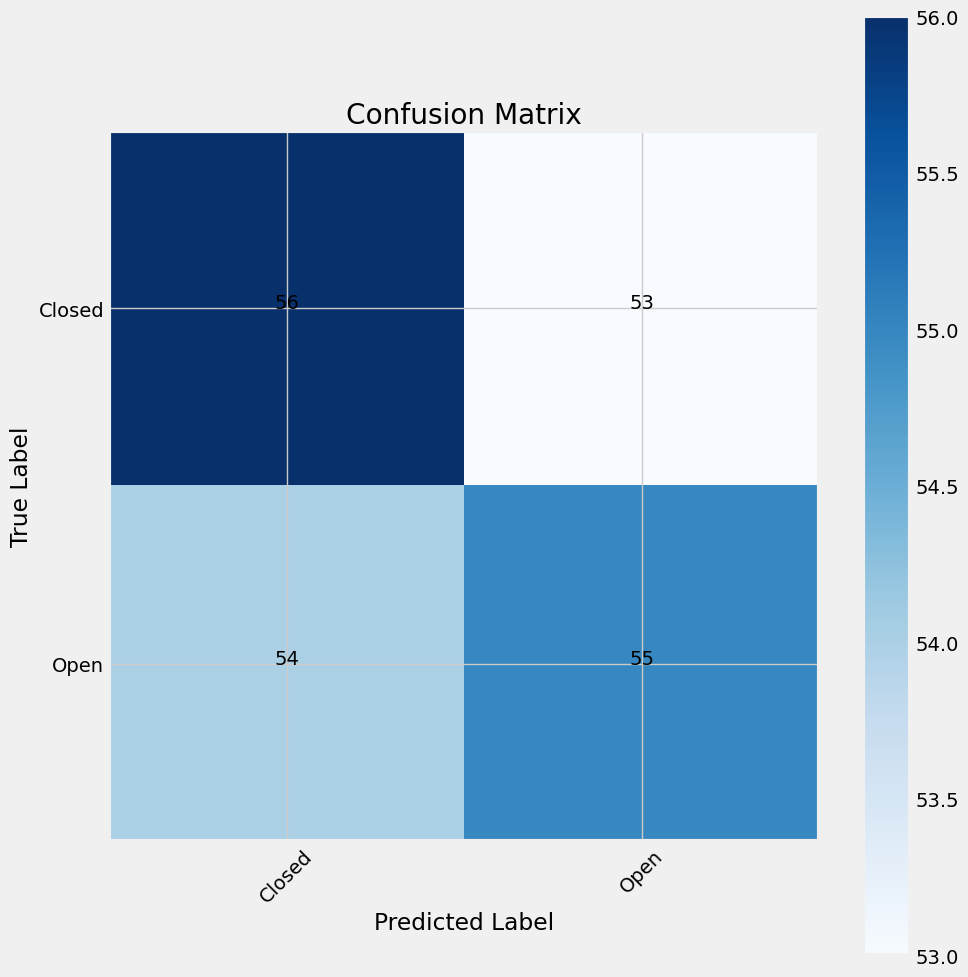

In [21]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'black' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [71]:
print(y_pred)
print(pred)

[1 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1
 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0
 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1
 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0]
[[1.60097680e-14 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [4.72533666e-18 1.00000000e+00]
 [1.00000000e+00 5.36814126e-21]
 [1.10450277e-16 1.00000000e+00]
 [3.56782030e-20 1.00000000e+00]
 [1.10666519e-18 1.00000000e+00]
 [1.00000000e+00 4.91819741e-21]
 [1.89614898e-13 1.00000000e+00]
 [9.34750378e-01 6.52495548e-02]
 [1.00000000e+00 1.31743268e-29]
 [5.56963413e-18 1.00000000e+00]
 [1.04675298e-14 1.00000000e+00]
 [1.24187097e-12 1.00000000e+00]
 [6.74268846e-15 1.00000000e+00]
 [1.00000000e+00 1.21162371e-26]
 [2.07602185e-15 1.00000000e+

1/1 [==============================] - 0s 32ms/step
[[5.8562785e-13 1.0000000e+00]
 [1.0000000e+00 1.0618461e-15]
 [4.3838302e-18 1.0000000e+00]
 [1.0000000e+00 1.1397228e-11]] [1 0 1 0] [1 0 1 0]
values finished


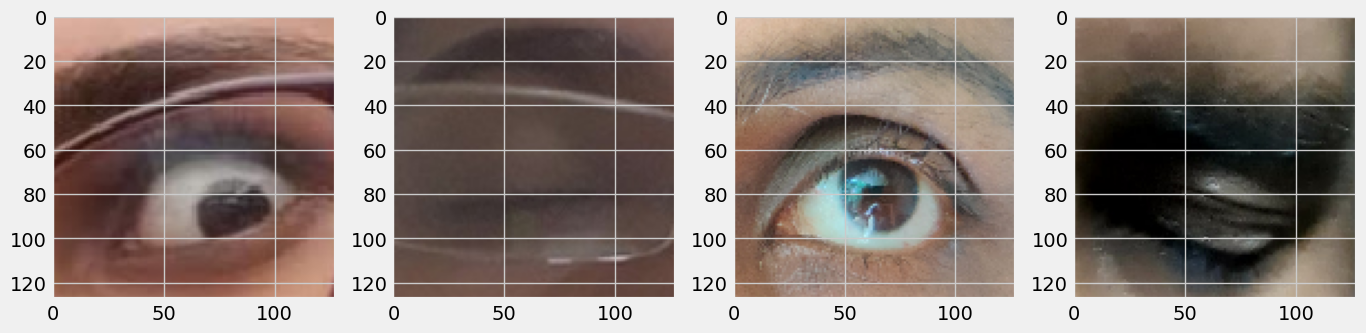

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

i = 0
for thing in test_generator:
  pred = model.predict(thing[0])
  np_pred = np.argmax(pred, axis = 1)
  # ax[0].imshow(thing[0][0])
  # ax[1].imshow(thing[0][1])
  # ax[2].imshow(thing[0][2])
  # ax[3].imshow(thing[0][3])
  # fig.show()
  print(pred, np_pred, np.argmax(thing[1], axis = 1))
  break

print("values finished")